# Neal's Funnel Target Practice

In [1]:
] activate "../"

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

@model function true_funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), I)
    zz = z .* exp(θ/2)
    x ~ MvNormal(zz, I)
    
end

true_funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Random.seed!(1)
(;x) = rand(true_funnel() | (θ=0,))
true_model = true_funnel() | (;x)

DynamicPPL.Model{typeof(true_funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(true_funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [0.7273459156073062, -0.7137895625029701, -1.3112158987551843, 3.195064335503728, 0.6578668590997088, 1.8201670957594605, 2.5774094189910475, 1.2959606640141557, -2.615684720848553, -1.7192495259048919, 0.38510954102334116, 0.7049475219687015, 1.4527158089056038, 1.5438517444010695, 0.8504145036053463, 0.9997932200168839, -0.14767140951984356, 0.6046583528834097, -0.38477500804604936, -1.506202996455002],), DynamicPPL.DefaultContext()))

## MCHMC

In [10]:
alpha_eps = 0.25
alpha_L = 0.11

truth_alpha_eps = 0.25
truth_alpha_L = 0.11;

┌ Error: Failed to revise /home/jaimerz/Glamdring/MicroCanonicalHMC.jl/src/targets.jl
│   exception =
│    invalid redefinition of constant CustomTarget
│    Stacktrace:
│     [1] top-level scope
│       @ ~/Glamdring/MicroCanonicalHMC.jl/src/targets.jl:119
│    Revise evaluation error at /home/jaimerz/Glamdring/MicroCanonicalHMC.jl/src/targets.jl:119
│    
└ @ Revise ~/.julia/packages/Revise/VRgaS/src/packagedef.jl:714
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /home/jaimerz/Glamdring/MicroCanonicalHMC.jl/src/targets.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.
└ @ Revise ~/.julia/packages/Revise/VRgaS/src/packagedef.jl:824


In [11]:
target = TuringTarget(funnel_model; d=d, compute_MAP=false)
true_target = TuringTarget(true_model; d=d, compute_MAP=false)

TuringTarget(DynamicPPL.Model{typeof(true_funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(true_funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [0.7273459156073062, -0.7137895625029701, -1.3112158987551843, 3.195064335503728, 0.6578668590997088, 1.8201670957594605, 2.5774094189910475, 1.2959606640141557, -2.615684720848553, -1.7192495259048919, 0.38510954102334116, 0.7049475219687015, 1.4527158089056038, 1.5438517444010695, 0.8504145036053463, 0.9997932200168839, -0.14767140951984356, 0.6046583528834097, -0.38477500804604936, -1.506202996455002],), DynamicPPL.DefaultContext())), 21, Any[θ, z1, z2, z3, z4, z5, z6, z7, z8, z9  …  z11, z12, z13, z14, z15, z16, z17, z18, z19, z20], ContinuousDistribution[Normal{Float64}(μ=0.0, σ=3.0), IsoNormal(
dim: 20
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 

In [12]:
spl = MCHMC(0.0, 0.0; init_eps=0.3, varE_wanted=0.01, sigma=ones(d))
samples_mchmc = Sample(spl, target, 100_000;
                       tuning_method="AdaptiveStep",
                       burn_in=5_000, dialog=false);

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Starting burn in ⏳


LoadError: BoundsError: attempt to access Bool at index [2]

In [9]:
spl_para = MCHMC(0.0, 0.0, 10; init_eps=0.3, varE_wanted=0.01, sigma=ones(d))
samples_mchmc_para = Sample(spl_para, target, 10_000;
                       tuning_method="AdaptiveStep",
                       burn_in=500, dialog=false);

LoadError: TaskFailedException

[91m    nested task error: [39mStackOverflowError:
    Stacktrace:
     [1] [0m[1mMvNormal[22m[0m[1m([22m[90mμ[39m::[0mVector[90m{Real}[39m, [90mΣ[39m::[0mPDMats.ScalMat[90m{Bool}[39m[0m[1m)[22m[90m (repeats 79984 times)[39m
    [90m   @[39m [36mDistributions[39m [90m~/.julia/packages/Distributions/bQ6Gj/src/multivariate/[39m[90m[4mmvnormal.jl:192[24m[39m

...and 9 more exceptions.


In [106]:
true_spl = MCHMC(0.0, 0.0; init_eps=0.3, varE_wanted=0.01, sigma=ones(d))
truth_mchmc = Sample(true_spl, true_target, 100_000;
               burn_in=20_000, dialog=false);

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Starting burn in ⏳
[ Info: Virial loss condition met during burn-in at step: 1
[ Info: Found L: 3.7324397209667683 ✅


In [113]:
theta_mchmc = [sample[1] for sample in samples_mchmc]
x10_mchmc = [sample[10+1] for sample in samples_mchmc]
E = [sample[end-1] for sample in samples_mchmc];

In [114]:
true_theta_mchmc = [sample[1] for sample in truth_mchmc]
true_x10_mchmc = [sample[10+1] * exp(sample[1]/2) for sample in truth_mchmc];

In [115]:
VarE = std(E)^2/d

0.01521683659485414

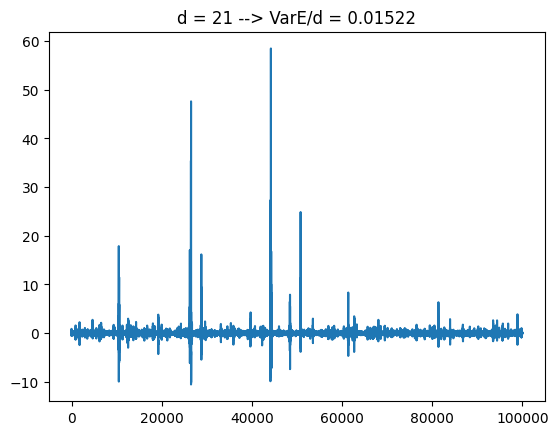

PyObject Text(0.5, 1.0, 'd = 21 --> VarE/d = 0.01522')

In [116]:
plt.plot(E, label="E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE, digits=5)))

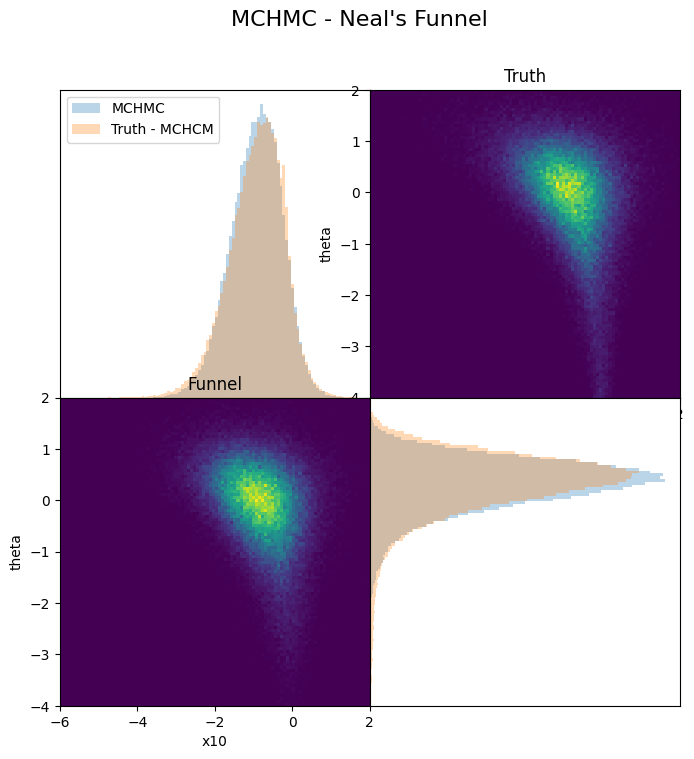

In [117]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("MCHMC - Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, density=true, label="MCHMC")
axis[1,1].hist(true_x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, density=true, label="Truth - MCHCM")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].hist(true_theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_mchmc, true_theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Truth")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("Funnel")
;

## NUTS

In [14]:
samples_hmc = sample(funnel_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.8250000000000001
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 22.73 seconds
Compute duration  = 22.73 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

           θ   -0.0629    0.8113     0.0036    0.0147    2449.4497    1.0000   ⋯
        z[1]    0.3552    0.7142     0.0032    0.0036   52192.0241    1.0000   ⋯
        z[2]   -0.3498    0.7108     0.0032    0.0030   56506.8625    1.0000   ⋯
        z[3]   -0.6

In [15]:
truth_hmc = sample(true_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 1.6
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:32


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 34.95 seconds
Compute duration  = 34.95 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

           θ   -0.0636    0.8880     0.0040    0.0091    9989.3125    1.0000   ⋯
        z[1]    0.3393    0.7167     0.0032    0.0023   89812.3178    1.0000   ⋯
        z[2]   -0.3326    0.7089     0.0032    0.0023   88583.0746    1.0000   ⋯
        z[3]   -0.6

In [16]:
theta_hmc = [samples_hmc.value.data[i, 1, :][1] for i in axes(samples_hmc.value.data)[1]]
x10_hmc = [samples_hmc.value.data[i, 10+1, :][1] for i in axes(samples_hmc.value.data)[1]];


In [17]:
true_theta_hmc = [truth_hmc.value.data[i, 1, :][1] for i in axes(truth_hmc.value.data)[1]]
true_x10_hmc = [truth_hmc.value.data[i, 10+1, :][1] * exp(truth_hmc.value.data[i, 1, :][1]/2) for i in axes(truth_hmc.value.data)[1]];


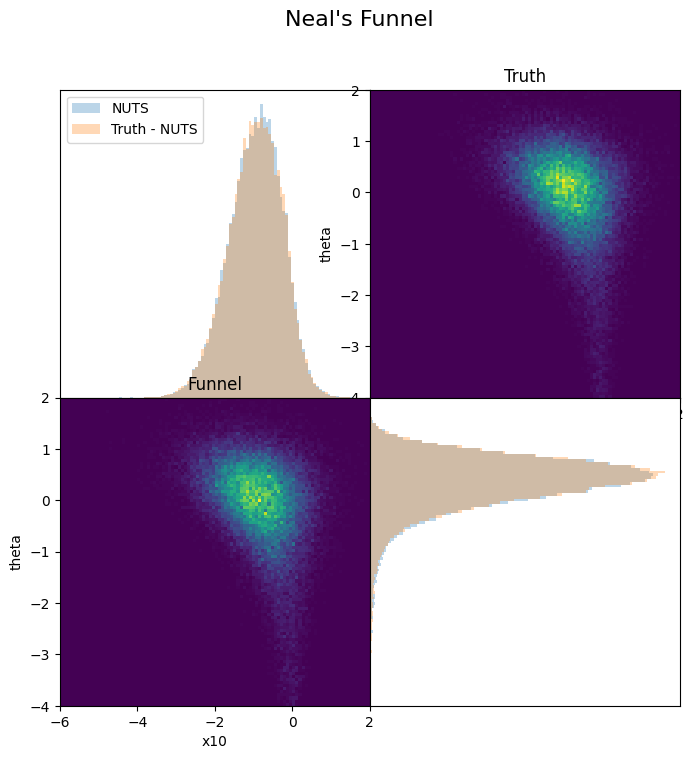

In [18]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="NUTS")
axis[1,1].hist(true_x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="Truth - NUTS")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Truth")

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("Funnel")
;

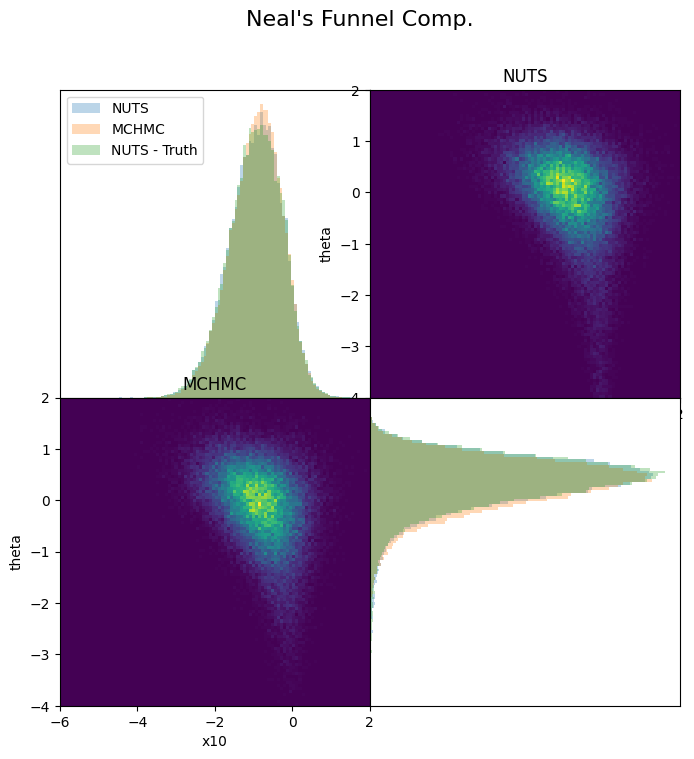

In [19]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="NUTS")
axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, label="MCHMC")
axis[1,1].hist(true_x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="NUTS - Truth")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100,  orientation="horizontal", range=[-6,2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")
;